In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dropout


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
# load the dataset as time series data
df = pd.read_csv('fifthClean.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_22096\705661990.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('fifthClean.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


,Latitude,Longitude,Year,Month,Day,Hour,Minute,Second
0,51.513952,-0.085833,2019,12,1,2,17,49
1,51.511625,-0.081549,2019,12,2,3,14,4
2,51.509775,-0.085014,2019,12,2,4,51,16
3,51.517431,-0.082458,2019,12,3,9,48,8
4,51.516814,-0.081620,2019,12,4,2,53,26


In [4]:
# scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(df))

In [5]:
# create time_steps to be used in the LSTM model
time_steps = 10
# create a function to create the time steps
def create_time_steps(df, time_steps):
    X = []
    y = []
    for i in range(len(df)-time_steps):
        X.append(df.iloc[i:(i+time_steps)].values)
        y.append(df.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

# create the time steps
X, y = create_time_steps(df,time_steps)
print(X.shape)
print(y.shape)


(2084, 10, 8)
(2084, 8)


In [6]:
print(X)


[[[0.29441565 0.18853324 0.         ... 0.08695652 0.28813559 0.83050847]
  [0.27347659 0.20698134 0.         ... 0.13043478 0.23728814 0.06779661]
  [0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  ...
  [0.32796134 0.22018009 0.         ... 0.52173913 0.62711864 0.30508475]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.52542373 0.49152542]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.74576271 0.49152542]]

 [[0.27347659 0.20698134 0.         ... 0.13043478 0.23728814 0.06779661]
  [0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  [0.32572076 0.20306693 0.         ... 0.39130435 0.81355932 0.13559322]
  ...
  [0.33319836 0.17832735 0.         ... 0.2173913  0.52542373 0.49152542]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.74576271 0.49152542]
  [0.32016881 0.2066756  0.         ... 0.26086957 0.22033898 0.13559322]]

 [[0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  [0.32572076 0.203066

In [7]:
# reshape y to dim 3
y = y.reshape((y.shape[0], y.shape[1], 1))
print(X.shape, y.shape)

(2084, 10, 8) (2084, 8, 1)


In [8]:
# split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1667, 10, 8) (1667, 8, 1) (417, 10, 8) (417, 8, 1)


In [9]:
def plot_mae(history,range,title): #plot the mae
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.ylabel('Validation mae')
    plt.xlabel('Epochs')
    plt.plot(history['mae'][:range], label='Training mae', color='red')
    plt.plot(history['val_mae'][:range], label='Validation mae', color='green')
    # set x interval to 1
    plt.xticks(np.arange(0, range, 1.0))

    plt.legend(
        loc='upper right',
        shadow=True,
        fontsize='x-large'
    )
    plt.show()

Epoch 1/100
4/4 [==============================] - 5s 284ms/step - loss: 0.2047 - mae: 0.3598 - val_loss: 0.0725 - val_mae: 0.2058
Epoch 2/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0605 - mae: 0.1886 - val_loss: 0.0555 - val_mae: 0.1777
Epoch 3/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0549 - mae: 0.1767 - val_loss: 0.0503 - val_mae: 0.1682
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0500 - mae: 0.1677 - val_loss: 0.0463 - val_mae: 0.1619
Epoch 5/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0448 - mae: 0.1575 - val_loss: 0.0441 - val_mae: 0.1543
Epoch 6/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0439 - mae: 0.1542 - val_loss: 0.0485 - val_mae: 0.1654
Epoch 7/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0446 - mae: 0.1559 - val_loss: 0.0422 - val_mae: 0.1502
Epoch 8/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0430 - mae: 0.1

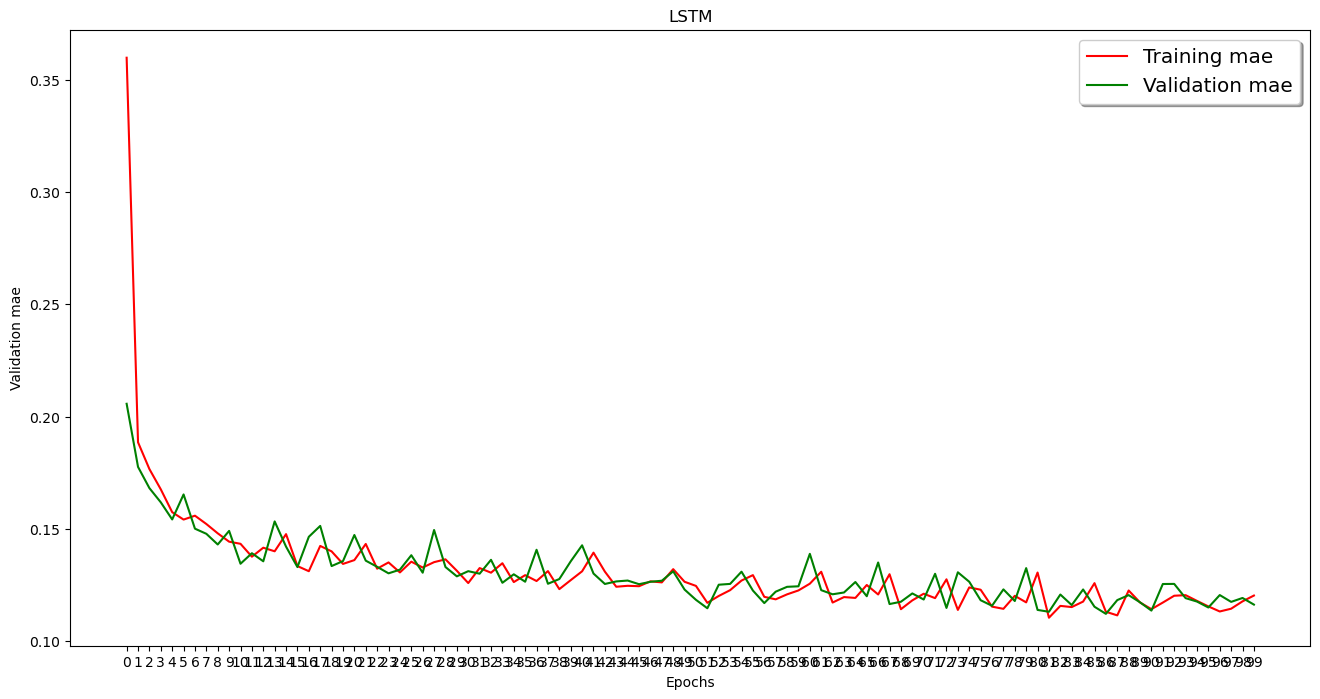

In [10]:
model = models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(32, return_sequences=True))
# model.add(layers.LSTM(512, return_sequences=True))
# model.add(layers.LSTM(256, return_sequences=True))
# model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(8))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# fit model
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=512)

# plot the mae
plot_mae(history.history,100,'LSTM')



In [11]:
# predict the test set
y_pred = model.predict(X_test)
print(y_pred.shape)

14/14 [==============================] - 1s 7ms/step
(417, 8)


In [12]:
# print the first 10 predictions
print(y_pred[:1])
# reshape y_test to dim 2
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
print(y_test.shape)

[[0.29191446 0.14489329 0.9921731  0.5380196  0.62768936 0.6087723
  0.5192402  0.43732572]]
(417, 8)


Conclusion: The prototype is working, but I was not able to invert the data back to its orginal form, so I can not use this approach for the final project. After some more indepth research and support from my ML lecturer. I was adivced to use a different approach, as currently, I am using multiple crimes topredict the next crime. This did not make much sence although the result shows positivily and strong connection between the crimes. I was advised to focus on one crime type and predict the next same crime. e.g. if the crime is burglary, then predict the next burglary. This will be the a better approach for the final project. Focusing on single crime type will also help to reduce the number of features and make the model more accurate and make it easier to interpret the results.
My next steps:
1. data cleaning and feature engineering 
2. data exploration and visualization before building the model
3. Ensure the time steps are correctlly scaled and inverted back to its original form for model evaluation
4. build a new model and evaluate the results